<a href="https://colab.research.google.com/github/DyatlovaA/cv-tf/blob/main/%D0%9F%D0%A04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CelebA (Celebrity Faces) — это интересный и достаточно сложный датасет для генерации лиц с помощью GAN

План работы:
Загрузка и подготовка данных (обрежем до 64x64 или 128x128).

Архитектура GAN (используем DCGAN для стабильного обучения).

Обучение (40+ эпох) с сохранением примеров генерации.

Визуализация результатов (графики loss, примеры изображений).

Оценка качества (например, FID или визуальный анализ).

#Загрузка датасета CelebA

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tensorflow.keras import layers

!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celebA.zip
!unzip -q celebA.zip -d celebA

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
From (redirected): https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684&confirm=t&uuid=b34821dd-0d7b-415f-a5e5-b1557a7f1918
To: /content/celebA.zip
100% 1.44G/1.44G [07:01<00:00, 3.42MB/s]
replace celebA/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace celebA/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A
A


#Подготовка данных

создаем конвейер загрузки и предобработки изображений для обучения GAN

In [ ]:
# Параметры
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EPOCHS = 40
noise_dim = 100

# Загрузка и предобработка
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = (img - 127.5) / 127.5  # Нормализация в [-1, 1]
    return img

# Создание tf.data.Dataset
dataset = tf.data.Dataset.list_files('celebA/img_align_celeba/*.jpg')
dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#Архитектура DCGAN

Реализуем генератор и дискриминатор на основе DCGAN.
Генератор (преобразует шум в изображение 64x64x3)

In [ ]:
def make_generator():
    model = tf.keras.Sequential([
        layers.Dense(8*8*512, use_bias=False, input_shape=(noise_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Reshape((8, 8, 512)),
        layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', activation='tanh')
    ])
    return model

Дискриминатор (классификатор "реальное/фейковое")

In [ ]:
def make_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[IMG_HEIGHT, IMG_WIDTH, 3]),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

Функции потерь и оптимизаторы

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output)*0.9, real_output)  # Label smoothing
    fake_loss = cross_entropy(tf.zeros_like(fake_output)*0.1, fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = make_generator()
discriminator = make_discriminator()

# Разные learning rates
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5)  # Меньше LR для дискриминатора

#Обучение GAN

Обучение с трекингом loss и оптимизаторы

Старт обучения...


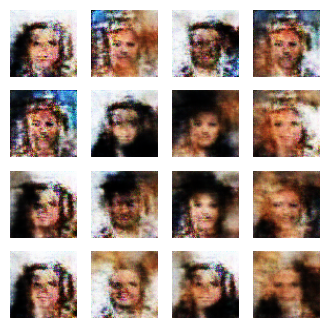

Эпоха 1, G_loss: 0.7108, D_loss: 1.4929
Время эпохи: 224.03 сек
Эпоха 2, G_loss: 0.7906, D_loss: 1.3865
Время эпохи: 212.43 сек
Эпоха 3, G_loss: 0.7955, D_loss: 1.3801
Время эпохи: 212.44 сек
Эпоха 4, G_loss: 0.7968, D_loss: 1.3785
Время эпохи: 212.35 сек


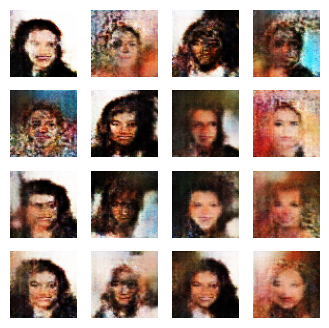

Эпоха 5, G_loss: 0.7971, D_loss: 1.3779
Время эпохи: 212.73 сек
Эпоха 6, G_loss: 0.7973, D_loss: 1.3775
Время эпохи: 212.46 сек
Эпоха 7, G_loss: 0.7975, D_loss: 1.3771
Время эпохи: 212.68 сек
Эпоха 8, G_loss: 0.7978, D_loss: 1.3768
Время эпохи: 212.58 сек
Эпоха 9, G_loss: 0.7980, D_loss: 1.3768
Время эпохи: 212.53 сек


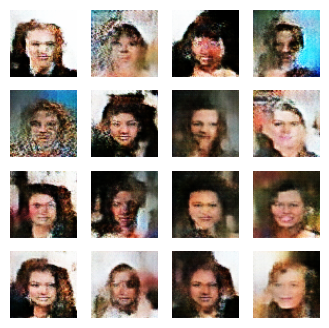

Эпоха 10, G_loss: 0.7980, D_loss: 1.3767
Время эпохи: 212.80 сек
Эпоха 11, G_loss: 0.7980, D_loss: 1.3767
Время эпохи: 212.36 сек
Эпоха 12, G_loss: 0.7981, D_loss: 1.3767
Время эпохи: 212.24 сек
Эпоха 13, G_loss: 0.7981, D_loss: 1.3766
Время эпохи: 212.57 сек
Эпоха 14, G_loss: 0.7982, D_loss: 1.3766
Время эпохи: 215.74 сек


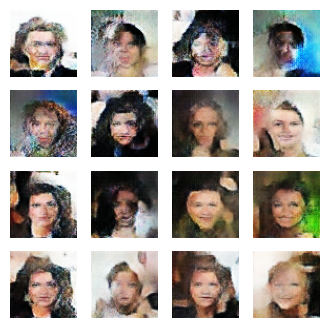

Эпоха 15, G_loss: 0.7982, D_loss: 1.3766
Время эпохи: 201.02 сек
Эпоха 16, G_loss: 0.7983, D_loss: 1.3766
Время эпохи: 200.82 сек
Эпоха 17, G_loss: 0.7983, D_loss: 1.3765
Время эпохи: 200.98 сек
Эпоха 18, G_loss: 0.7983, D_loss: 1.3765
Время эпохи: 200.86 сек
Эпоха 19, G_loss: 0.7983, D_loss: 1.3765
Время эпохи: 200.99 сек


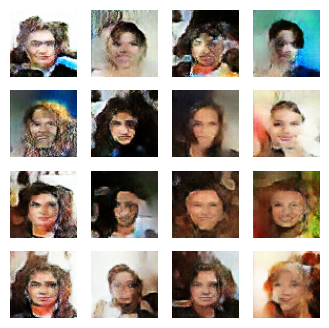

Эпоха 20, G_loss: 0.7983, D_loss: 1.3765
Время эпохи: 201.23 сек
Эпоха 21, G_loss: 0.7984, D_loss: 1.3765
Время эпохи: 201.01 сек
Эпоха 22, G_loss: 0.7984, D_loss: 1.3765
Время эпохи: 200.98 сек
Эпоха 23, G_loss: 0.7984, D_loss: 1.3765
Время эпохи: 201.11 сек
Эпоха 24, G_loss: 0.7984, D_loss: 1.3765
Время эпохи: 200.82 сек


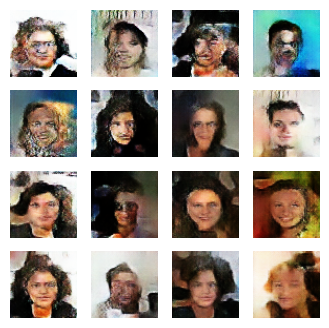

Эпоха 25, G_loss: 0.7984, D_loss: 1.3765
Время эпохи: 201.04 сек
Эпоха 26, G_loss: 0.7984, D_loss: 1.3765
Время эпохи: 200.97 сек
Эпоха 27, G_loss: 0.7984, D_loss: 1.3765
Время эпохи: 200.94 сек
Эпоха 28, G_loss: 0.7984, D_loss: 1.3765
Время эпохи: 200.87 сек
Эпоха 29, G_loss: 0.7984, D_loss: 1.3765
Время эпохи: 201.02 сек


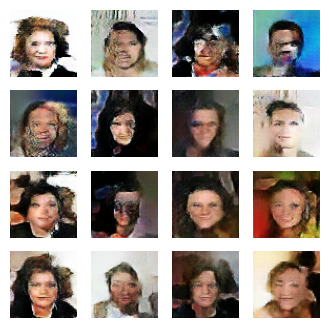

Эпоха 30, G_loss: 0.7984, D_loss: 1.3765
Время эпохи: 201.33 сек
Эпоха 31, G_loss: 0.7984, D_loss: 1.3765
Время эпохи: 200.88 сек
Эпоха 32, G_loss: 0.7984, D_loss: 1.3765
Время эпохи: 200.85 сек
Эпоха 33, G_loss: 0.7984, D_loss: 1.3765
Время эпохи: 200.90 сек
Эпоха 34, G_loss: 0.7984, D_loss: 1.3765
Время эпохи: 200.88 сек


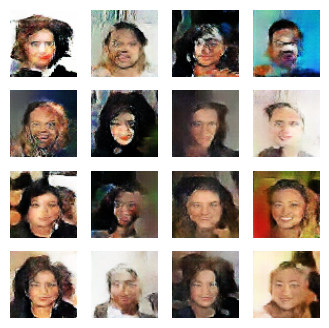

Эпоха 35, G_loss: 0.7984, D_loss: 1.3765
Время эпохи: 201.12 сек
Эпоха 36, G_loss: 0.7984, D_loss: 1.3765
Время эпохи: 200.89 сек
Эпоха 37, G_loss: 0.7984, D_loss: 1.3764
Время эпохи: 200.98 сек
Эпоха 38, G_loss: 0.7984, D_loss: 1.3765
Время эпохи: 200.97 сек
Эпоха 39, G_loss: 0.7984, D_loss: 1.3765
Время эпохи: 200.98 сек


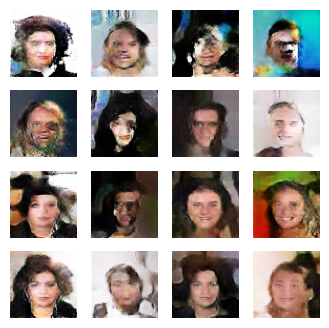

Эпоха 40, G_loss: 0.7984, D_loss: 1.3765
Время эпохи: 201.16 сек


In [ ]:
# Инициализация списков для хранения loss
generator_losses = []
discriminator_losses = []

# Фиксированный шум для отслеживания прогресса генерации
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        # Добавляем шум к реальным изображениям для стабилизации
        real_output = discriminator(images + tf.random.normal(tf.shape(images), stddev=0.01), training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_save_images(model, epoch, test_input):
    """Генерирует и сохраняет 16 изображений в сетке 4x4"""
    predictions = model(test_input, training=False)

    plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i] * 0.5 + 0.5)  # Денормализация [-1,1] -> [0,1]
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        epoch_gen_loss = []
        epoch_disc_loss = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            epoch_gen_loss.append(gen_loss)
            epoch_disc_loss.append(disc_loss)

        # Сохраняем средние loss за эпоху
        generator_losses.append(tf.reduce_mean(epoch_gen_loss))
        discriminator_losses.append(tf.reduce_mean(epoch_disc_loss))

        # Генерация примеров каждые 5 эпох
        if (epoch + 1) % 5 == 0 or epoch == 0:
            generate_and_save_images(generator, epoch + 1, seed)

        print(f"Эпоха {epoch+1}, G_loss: {generator_losses[-1]:.4f}, D_loss: {discriminator_losses[-1]:.4f}")
        print(f"Время эпохи: {time.time() - start:.2f} сек")

# Запуск обучения
print("Старт обучения...")
train(dataset, EPOCHS)

#Оценка качества

#Выводы